In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import albumentations
from albumentations.pytorch import ToTensorV2
import math
import gc
import pdb
import warnings
from tensorboardX import SummaryWriter
from itertools import product
from fas14mnet.net import Fas14MNet

torch.set_printoptions(linewidth=120)
warnings.filterwarnings("ignore")
root='/media/codebuster/New Volume/personal'

In [2]:
data = pd.read_csv(os.path.join(root, "fashion/filtered.csv"), index_col=False)
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
41172,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top
41173,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
41174,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
41175,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt


In [3]:
file_paths = []
categories = data.subCategory.unique()
print("Number of sub-categories: {}".format(len(categories)))
for cat in categories:
    print(cat)
    df = data[data.subCategory==cat]
    imageId = random.choice(df.id.tolist())
    file_paths.append(os.path.join(root, "fashion/images/{}.jpg".format(imageId)))

Number of sub-categories: 18
Topwear
Bottomwear
Watches
Socks
Shoes
Belts
Flip Flops
Bags
Innerwear
Sandal
Jewellery
Saree
Eyewear
Dress
Loungewear and Nightwear
Wallets
Headwear
Ties


In [4]:
transform = albumentations.Compose([
    albumentations.Resize(150, 150),
    albumentations.CenterCrop(100, 100),
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=1),
        albumentations.RandomRotate90(p=1),
        albumentations.VerticalFlip(p=1)
    ], p=1),
    albumentations.OneOf([
        albumentations.MotionBlur(p=1),
        albumentations.OpticalDistortion(p=1),
        albumentations.GaussNoise(p=1)
    ], p=1),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

In [5]:
def fetchTensor(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = Image.fromarray(image)
    aug = transform(image=image)
    image = aug['image']

    return original, image

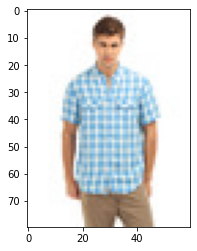

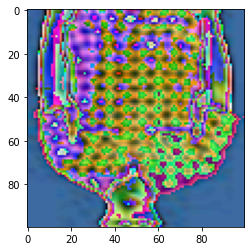

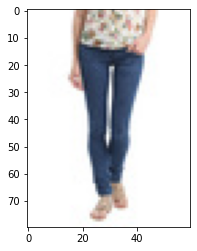

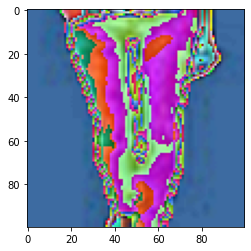

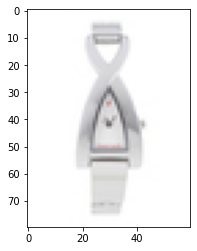

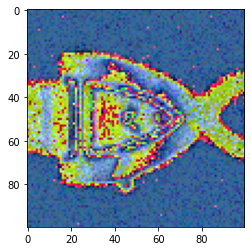

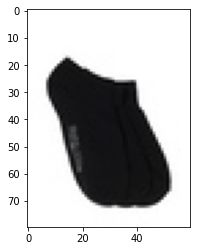

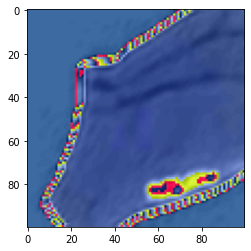

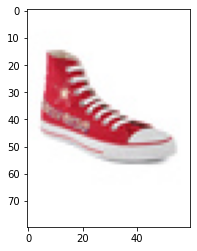

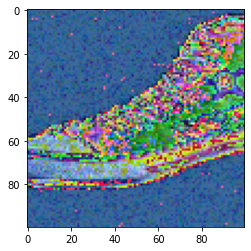

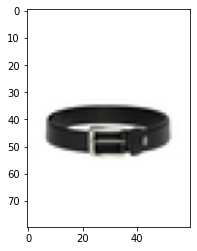

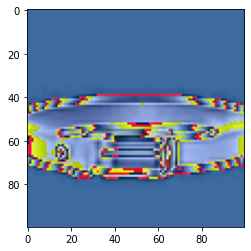

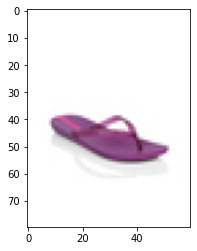

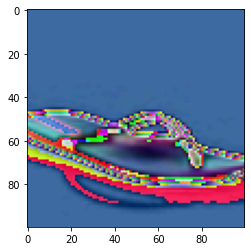

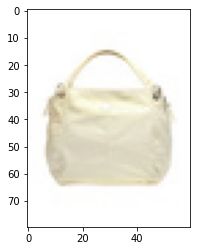

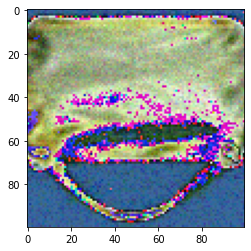

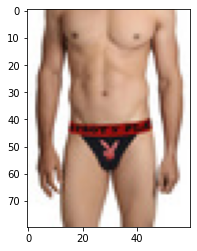

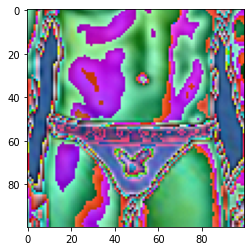

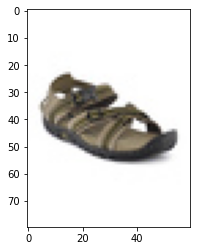

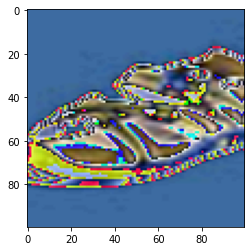

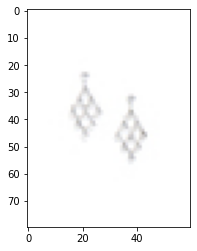

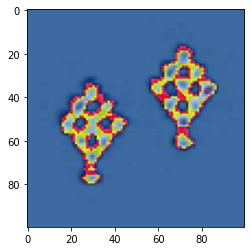

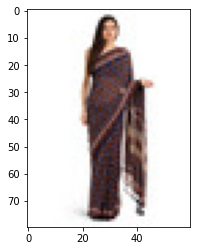

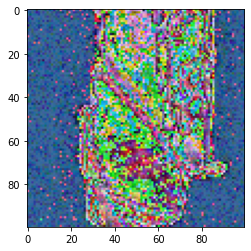

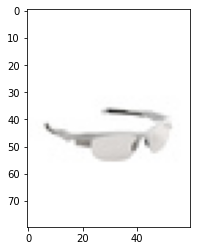

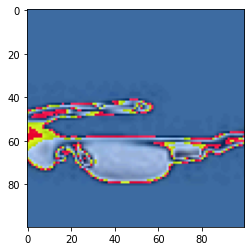

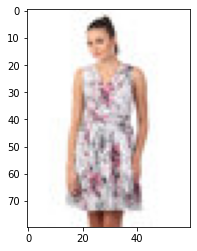

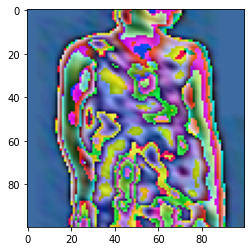

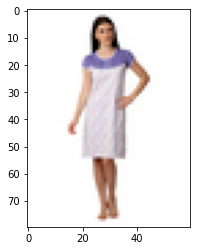

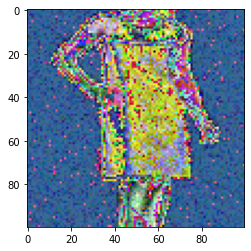

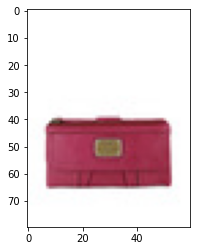

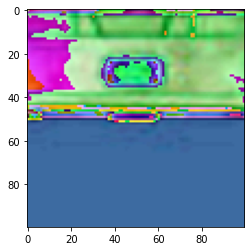

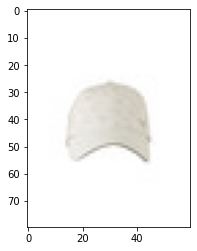

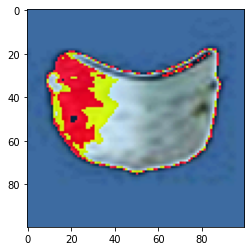

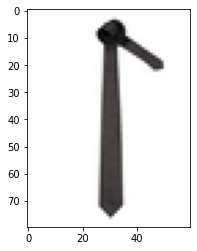

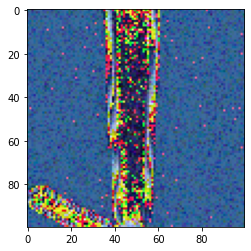

In [6]:
for idx in range(len(file_paths)):
    original, tensor = fetchTensor(file_paths[idx])
    plt.figure()
    plt.imshow(original)
    plt.figure()
    plt.imshow(transforms.ToPILImage()(tensor))

In [7]:
labels = data.subCategory.tolist()
label_encoder = preprocessing.LabelEncoder()
encoded = label_encoder.fit_transform(np.array(labels))
data.subCategory = encoded
num_classes = len(data.subCategory.unique())
num_classes

18

In [8]:
trainDf, testDf = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
trainDf, valDf = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)

temp = np.array([idx for idx in range(len(trainDf))])
trainDf['index'] = temp
trainDf.set_index('index', inplace=True)

temp = np.array([idx for idx in range(len(valDf))])
valDf['index'] = temp
valDf.set_index('index', inplace=True)

temp = np.array([idx for idx in range(len(testDf))])
testDf['index'] = temp
testDf.set_index('index', inplace=True)

print(trainDf.shape, valDf.shape, testDf.shape)

(28823, 10) (12354, 10) (8236, 10)


In [9]:
class FashionDataset(Dataset):
    
    def __init__(self, file_paths, labels, transform=None):
        
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        
        target = torch.tensor(self.labels[idx], dtype=torch.long)
        file = self.file_paths[idx]
        image = cv2.imread(file)
        
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                aug = self.transform(image=image)
                image = aug['image']
                
        except:
            image = torch.zeros(3, 100, 100)
            
        return image, target

In [10]:
train_file_paths = trainDf.id.tolist()
val_file_paths = valDf.id.tolist()

train_file_paths = [os.path.join(root, "fashion/images/{}.jpg".format(idx)) for idx in train_file_paths]
val_file_paths = [os.path.join(root, "fashion/images/{}.jpg".format(idx)) for idx in val_file_paths]

In [11]:
criterion = nn.CrossEntropyLoss()
batch_size = 48
epochs = 50

In [12]:
trainDataset = FashionDataset(file_paths=train_file_paths, labels=np.array(trainDf.subCategory), 
                              transform=transform)
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

valDataset = FashionDataset(file_paths=val_file_paths, labels=np.array(valDf.subCategory),
                            transform=transform)
valDataLoader = DataLoader(valDataset, batch_size=batch_size, shuffle=True)

In [13]:
model = Fas14MNet(num_classes=num_classes)
model

Fas14MNet(
  (conv0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Core(
      (layer0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (layer1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3

In [14]:
print("Total Trainable Parameters: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Total Trainable Parameters: 14854994


In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, verbose=False)

In [16]:
def fetchLossAcc(output, labels):
    
    loss = criterion(output, labels)
    pred = output.detach().cpu().numpy()
    pred = [np.argmax(pred[idx]) for idx in range(len(pred))]
    labels = labels.detach().cpu().numpy()
    correct = [True for i in range(len(labels)) if labels[i]==pred[i]]
    acc = len(correct)/len(labels)
    
    return loss, acc, labels, pred

In [17]:
tb = SummaryWriter()

In [18]:
for epoch in tqdm(range(epochs)):
    
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    rounds = 0
    
    model.to(device='cuda')
    model.train()
    
    for i, (images, labels) in enumerate(trainDataLoader):
        
        images = Variable(images).to(device='cuda')
        labels = Variable(labels).to(device='cuda')
        
        optimizer.zero_grad()
        output = model(images)
        loss, acc, _, _ = fetchLossAcc(output, labels)
        
        train_loss += loss.item()
        train_acc += acc
        
        loss.backward()
        optimizer.step()
        rounds += 1
        
    
    train_loss /= rounds
    train_acc /= rounds
    
    scheduler.step()
    
    model.to(device='cpu')
    model.eval()
    rounds = 0
    
    for i, (images, labels) in enumerate(valDataLoader):
        
        output = model(images)
        loss, acc, _, _ = fetchLossAcc(output, labels)
        
        val_loss += loss.item()
        val_acc += acc
        
        rounds += 1
        
    val_loss /= rounds
    val_acc /= rounds
    
    tb.add_scalar("train_loss", train_loss, epoch+1)
    tb.add_scalar("val_loss", val_loss, epoch+1)
    tb.add_scalar("train_acc", train_acc, epoch+1)
    tb.add_scalar("val_acc", val_acc, epoch+1)
        
    for name, weight in model.named_parameters():
        tb.add_histogram(name, weight, epoch+1)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch+1)
    
    print("epoch: {} loss: {} val_loss: {} acc: {} val_acc: {}".format(epoch+1, round(train_loss, 4),
                                                                       round(val_loss, 4), round(train_acc, 4),
                                                                       round(val_acc, 4)))

epoch: 1 loss: 2.0653 val_loss: 1.5647 acc: 0.4722 val_acc: 0.5425
epoch: 2 loss: 1.3685 val_loss: 1.1581 acc: 0.5864 val_acc: 0.6504
epoch: 3 loss: 1.1416 val_loss: 0.9872 acc: 0.6499 val_acc: 0.6769
epoch: 4 loss: 1.0098 val_loss: 0.8808 acc: 0.687 val_acc: 0.7172
epoch: 5 loss: 0.9028 val_loss: 2.6132 acc: 0.7236 val_acc: 0.2107
epoch: 6 loss: 0.8144 val_loss: 0.7383 acc: 0.7505 val_acc: 0.7739
epoch: 7 loss: 0.7502 val_loss: 0.7062 acc: 0.7678 val_acc: 0.7773
epoch: 8 loss: 0.7087 val_loss: 0.7116 acc: 0.7837 val_acc: 0.7856
epoch: 9 loss: 0.6627 val_loss: 0.6042 acc: 0.7972 val_acc: 0.8169
epoch: 10 loss: 0.6354 val_loss: 2.5957 acc: 0.806 val_acc: 0.4605
epoch: 11 loss: 0.6066 val_loss: 0.5898 acc: 0.8165 val_acc: 0.8271
epoch: 12 loss: 0.5821 val_loss: 0.5481 acc: 0.8226 val_acc: 0.8364
epoch: 13 loss: 0.5672 val_loss: 1.2029 acc: 0.8279 val_acc: 0.7066
epoch: 14 loss: 0.5486 val_loss: 2.3035 acc: 0.8333 val_acc: 0.5487
epoch: 15 loss: 0.5291 val_loss: 0.4941 acc: 0.8415 val_acc

In [20]:
torch.save(model.state_dict(), os.path.join(root, "models/model.pth"))

In [21]:
test_transform = albumentations.Compose([
    albumentations.Resize(150, 150),
    albumentations.CenterCrop(100, 100),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

In [23]:
test_file_paths = testDf.id.tolist()
#test_file_paths = ["fashion/images/{}.jpg".format(idx) for idx in test_file_paths]
test_file_paths = [os.path.join(root, "fashion/images/{}.jpg".format(idx)) for idx in test_file_paths]

In [24]:
labels = np.array(testDf.subCategory)
testDataset = FashionDataset(file_paths=test_file_paths, labels=labels, transform=test_transform)
testDataLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

In [32]:
test_model = Fas14MNet(num_classes=num_classes)
test_model.load_state_dict(torch.load(os.path.join(root, "models/model.pth")))
test_model.to(device='cpu')
test_model.eval()

Fas14MNet(
  (conv0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Core(
      (layer0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (layer1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3

In [33]:
test_loss = 0.0
test_acc = 0.0
precision = 0.0
recall = 0.0
F1_score = 0.0
counter = 0

for i, (images, batch) in tqdm(enumerate(testDataLoader)):

    images = Variable(images)
    labels = Variable(batch)

    output = test_model(images)

    loss, acc, true, predictions = fetchLossAcc(output, labels)

    test_loss += loss.item()
    test_acc += acc

    precision += precision_score(true, predictions, average='weighted')
    recall += recall_score(true, predictions, average='weighted')
    F1_score += f1_score(true, predictions, average='weighted')

    counter += 1

precision /= counter
recall /= counter
F1_score /= counter
test_loss /= counter
test_acc /= counter

print("test_loss: {} test_acc: {} precision: {} recall: {} f1_score: {}".format(round(test_loss, 4), 
                                                                round(test_acc, 4), round(precision, 4), 
                                                                round(recall, 4), round(F1_score, 4)))


test_loss: 0.2888 test_acc: 0.9114 precision: 0.898 recall: 0.9114 f1_score: 0.8983


In [35]:
class PredictionDataset(Dataset):
    
    def __init__(self, file_paths, transform=None):
        
        self.file_paths = file_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        
        file_path = self.file_paths[idx]
        
        image = cv2.imread(file_path)
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                aug = self.transform(image=image)
                image = aug['image']
        except:
            image = torch.zeros(3, 100, 100)
        
        return image

In [50]:
def fetchPredictions(output):
    
    pred = output.detach().cpu().numpy()
    pred = [np.argmax(pred[idx]) for idx in range(len(pred))]
    
    return pred

In [51]:
to_predict = [random.choice(testDf.id.tolist()) for i in range(8)]
#paths = ["fashion/images/{}.jpg".format(idx) for idx in to_predict]
paths = [os.path.join(root, "fashion/images/{}.jpg".format(idx)) for idx in to_predict]

In [52]:
predDataset = PredictionDataset(file_paths=paths, transform=test_transform)
predDataLoader = DataLoader(predDataset, batch_size=8, shuffle=False)

In [53]:
predModel = Fas14MNet(num_classes=num_classes)
predModel.load_state_dict(torch.load(os.path.join(root, "models/model.pth")))
predModel.eval()

Fas14MNet(
  (conv0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Core(
      (layer0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (layer1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3

In [58]:
for i, images in tqdm(enumerate(predDataLoader)):
    
    images = Variable(images)
    output = predModel(images)
    pred = fetchPredictions(output)
    
    predictions = label_encoder.inverse_transform(np.array(pred))
    
    
    print("Predictions:")
    print()
    for idx in range(len(paths)):
        print("file: {} prediction: {}-{}".format(paths[idx], predictions[idx], pred[idx]))

Predictions:

file: /media/codebuster/New Volume/personal/fashion/images/5679.jpg prediction: Shoes-12
file: /media/codebuster/New Volume/personal/fashion/images/22563.jpg prediction: Topwear-15
file: /media/codebuster/New Volume/personal/fashion/images/17500.jpg prediction: Topwear-15
file: /media/codebuster/New Volume/personal/fashion/images/28002.jpg prediction: Innerwear-7
file: /media/codebuster/New Volume/personal/fashion/images/4365.jpg prediction: Topwear-15
file: /media/codebuster/New Volume/personal/fashion/images/6136.jpg prediction: Shoes-12
file: /media/codebuster/New Volume/personal/fashion/images/24509.jpg prediction: Topwear-15
file: /media/codebuster/New Volume/personal/fashion/images/7745.jpg prediction: Topwear-15



In [59]:
testDf[testDf.id.isin(to_predict)]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
index,,,,,,,,,,
373,24509,Women,Apparel,15,Kurtas,Black,Fall,2011.0,Ethnic,Mother Earth Women Black Printed Kurta
598,22563,Women,Accessories,0,Handbags,Brown,Winter,2015.0,Casual,Lino Perros Brown Women Casual Sling Bag
873,4365,Men,Apparel,15,Tshirts,Grey,Summer,2011.0,Casual,Free Authority Men's Masked Angel Washed Grey ...
1177,5679,Men,Footwear,12,Casual Shoes,Black,Winter,2015.0,Casual,Skechers Men's Diameter Heisman Black Shoe
1493,28002,Men,Apparel,7,Briefs,Grey,Summer,2016.0,Casual,Jockey ZONE Men Grey Tanga Brief US18
3133,6136,Unisex,Footwear,10,Sandals,Brown,Summer,2011.0,Casual,Puma Unisex Winch Brown Beige Floater
3418,7745,Men,Apparel,15,Tshirts,Purple,Fall,2011.0,Casual,Indigo Nation Men Polo Stripes Two Purple Blac...
6668,17500,Men,Apparel,15,Tshirts,Navy Blue,Fall,2011.0,Casual,Classic Polo Men Stripes Blue Polo T-Shirt
